In [2]:
%load_ext autoreload
%autoreload 2
import transformers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import cosine sim
from sklearn.metrics.pairwise import cosine_similarity
from collections import Counter, defaultdict
from sklearn.linear_model import SGDClassifier
# import mlp
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
# import pca
from sklearn.decomposition import PCA
import pickle
from sklearn.utils import shuffle, resample
from sklearn.model_selection import train_test_split
import torch
import tqdm
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, AutoConfig
import ot
import utils

In [9]:
def load_data(path, pca_dim=None, model_name=None):
    fnames = ["neg_neg", "neg_pos", "pos_neg", "pos_pos"]
    fnames = ["tweets_{}_Llama-2-7b-chat-hf_pooling:last_layer:last.npy".format(fname) for fname in fnames]
    protected_labels = [0, 1, 0, 1]
    main_labels = [0, 0, 1, 1]
    X, Y_p, Y_m = [], [], []

    for fname, p_label, m_label in zip(fnames, protected_labels, main_labels):
        #print(path + '/' + fname)
        data = np.load(path + '/' + fname)
        for x in data:
            X.append(x)
        for _ in data:
            Y_p.append(p_label)
        for _ in data:
            Y_m.append(m_label)

    Y_p = np.array(Y_p)
    Y_m = np.array(Y_m)
    X = np.array(X)
    X, Y_p, Y_m = shuffle(X, Y_p, Y_m, random_state=1)
    if pca_dim is not None:
        pca = PCA(n_components=pca_dim, random_state=1)
        X = pca.fit_transform(X)
        print("percentage of variance explained by first 256 components: ", np.sum(pca.explained_variance_ratio_[:256]))
        print("percentage of variance explained by first 512 components: ", np.sum(pca.explained_variance_ratio_[:512]))
    return X, Y_p, Y_m


def sample_bias(X,z,y, bias_level=0.1, train_prop = 0.6):
    np.random.seed(0)
    # the goal of this function is to create a biased dataset.
    # in bias_level, we are completely balanced wrt the main task (y), but we are biased wrt the protected attribute (z)
    # e.g, if bias_level=0.1, then the proportions within y=1 will be 0.1 and 0.9 for z=0 and z=1 respectively, and vice versa for y=0

    # first, we need to find the indices of the samples that have the desired label and protected attribute

    X,z,y = shuffle(X,z,y, random_state=1)

    y_1_z_1 = (y==1)&(z==1)
    y_1_z_0 = (y==1)&(z==0)
    y_0_z_1 = (y==0)&(z==1)
    y_0_z_0 = (y==0)&(z==0)

    # sample from these indices
    to_sample_from_z_1_y_1 = np.where(y_1_z_1)[0]
    to_sample_from_z_1_y_0 = np.where(y_1_z_0)[0]
    to_sample_from_z_0_y_1 = np.where(y_0_z_1)[0]
    to_sample_from_z_0_y_0 = np.where(y_0_z_0)[0]


    z_1_y_1_sample = np.random.choice(to_sample_from_z_1_y_1, int(len(to_sample_from_z_1_y_1)*bias_level), replace=False)
    z_1_y_0_sample = np.random.choice(to_sample_from_z_1_y_0, int(len(to_sample_from_z_1_y_0)*(1-bias_level)), replace=False)
    z_0_y_1_sample = np.random.choice(to_sample_from_z_0_y_1, int(len(to_sample_from_z_0_y_1)*(1-bias_level)), replace=False)
    z_0_y_0_sample = np.random.choice(to_sample_from_z_0_y_0, int(len(to_sample_from_z_0_y_0)*bias_level), replace=False)

    # concatenate these indices

    indices = np.concatenate((z_1_y_1_sample, z_1_y_0_sample, z_0_y_1_sample, z_0_y_0_sample))

    #  shuffle the indices

    indices = shuffle(indices, random_state=1)

    # split to train,dev,test

    train_indices = indices[:int(len(indices)*train_prop)]
    dev_indices = indices[int(len(indices)*train_prop):int(len(indices)*(train_prop+0.3))]
    test_indices = indices[int(len(indices)*(train_prop+0.3)):]

    return X[train_indices], z[train_indices], y[train_indices], X[dev_indices], z[dev_indices], y[dev_indices], X[test_indices], z[test_indices], y[test_indices]



In [10]:
bias2clf_before = {}
bias2clf_after = {}
bias2data_before = {}
bias2data_after = {}

bias2data_before_steer = {}
bias2data_after_steer = {}
bias2clf_before_steer = {}
bias2clf_after_steer = {}
num_examples = 150000
num_iters=50

for bias_level in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]:
        print("bias level = ", bias_level)
        X,z,y = load_data('tweets_encodings', pca_dim=768)

        x_train, z_train, y_train, x_dev, z_dev, y_dev, x_test, z_test, y_test = sample_bias(X,z,y, bias_level=bias_level)

        clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        clf.fit(x_train, y_train)
        clf, score_dev, score_test = utils.fit_logistic_regression(x_train, y_train, x_dev, y_dev, x_test, y_test, max_iter=num_iters)
        print("score before: ", score_dev, "majority:", max(Counter(y_dev).values())/len(y_dev))
        bias2clf_before[str(bias_level)] = clf
        bias2data_before[str(bias_level)] = {"x_train": x_train, "y_train": y_train, "z_train": z_train, "x_dev": x_dev, "y_dev": y_dev, "z_dev": z_dev,
                                             "x_test": x_test, "y_test": y_test, "z_test": z_test}
        


        gender_clf = SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        gender_clf.fit(x_train, z_train)
        dev_z_pred = gender_clf.predict(x_dev)
        train_z_pred =  gender_clf.predict(x_train)

        z_labels_train = train_z_pred
        z_labels_dev = dev_z_pred
        
        x_train_source = x_train[z_labels_train==0]
        x_train_target = x_train[z_labels_train==1]

        ot_linear = ot.da.LinearTransport(reg=1e-5)
        ot_linear.fit(Xs=x_train_source, Xt=x_train_target)

        (train_x_transformed, dev_x_transformed, test_x_transformed), (train_x_transformed_steering, dev_x_transformed_steering, test_x_transformed_steering) = utils.apply_steering(gender_clf, ot_linear, x_train, x_dev, x_test, z_labels_train)


        bias2data_after[str(bias_level)] = {"x_train": train_x_transformed, "y_train": y_train, "z_train": z_train, "x_dev": dev_x_transformed, "y_dev": y_dev, "z_dev": z_dev,
                                             "x_test": test_x_transformed, "y_test": y_test, "z_test": z_test}
        bias2data_after_steer[str(bias_level)] = {"x_train": train_x_transformed_steering, "y_train": y_train, "z_train": z_train, "x_dev": dev_x_transformed_steering, "y_dev": y_dev, "z_dev": z_dev,
                                                  "x_test": test_x_transformed_steering, "y_test": y_test, "z_test": z_test}
        clf_after, score_after, _ = utils.fit_logistic_regression(train_x_transformed, y_train, dev_x_transformed, y_dev, test_x_transformed, y_test, max_iter=num_iters)
        clf_after_steering, score_after_steering, _ = utils.fit_logistic_regression(train_x_transformed_steering, y_train, dev_x_transformed_steering, y_dev, test_x_transformed_steering, y_test, max_iter=num_iters)
        #SGDClassifier(loss='log_loss', penalty='l2', random_state=0, max_iter=500000, tol=1e-4)
        #clf_after.fit(train_x_transformed, y_train)
        print("score after:", score_after, "majority:", max(Counter(y_dev).values())/len(y_dev))
        print("score after steering:", score_after_steering, "majority:", max(Counter(y_dev).values())/len(y_dev))
        bias2clf_after[str(bias_level)] = clf_after
        bias2clf_after_steer[str(bias_level)] = clf_after_steering



bias level =  0.5
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.29012605
Epoch 3, change: 0.19857807
Epoch 4, change: 0.11741862
Epoch 5, change: 0.07736135
Epoch 6, change: 0.06023907
Epoch 7, change: 0.03783469
Epoch 8, change: 0.02257102
Epoch 9, change: 0.02007453
Epoch 10, change: 0.01013829
Epoch 11, change: 0.00811678
Epoch 12, change: 0.00473739
Epoch 13, change: 0.00333032
Epoch 14, change: 0.00291538
Epoch 15, change: 0.00121207
Epoch 16, change: 0.00084534
Epoch 17, change: 0.00054339
Epoch 18, change: 0.00048593
Epoch 19, change: 0.00027082
Epoch 20, change: 0.00019495
Epoch 21, change: 0.00011589
convergence after 22 epochs took 15 seconds
score before:  0.8570400393954316 majority: 0.5008523050115534


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20157546
Epoch 3, change: 0.09546326
Epoch 4, change: 0.07131892
Epoch 5, change: 0.04338864
Epoch 6, change: 0.02618928
Epoch 7, change: 0.02248481
Epoch 8, change: 0.01388154
Epoch 9, change: 0.00943111
Epoch 10, change: 0.00624102
Epoch 11, change: 0.00517748
Epoch 12, change: 0.00325221
Epoch 13, change: 0.00263870
Epoch 14, change: 0.00206700
Epoch 15, change: 0.00190250
Epoch 16, change: 0.00151373
Epoch 17, change: 0.00117570
Epoch 18, change: 0.00101527
Epoch 19, change: 0.00091802
Epoch 20, change: 0.00081437
Epoch 21, change: 0.00070116
Epoch 22, change: 0.00056618
Epoch 23, change: 0.00045689
Epoch 24, change: 0.00038719
Epoch 25, change: 0.00041381
Epoch 26, change: 0.00031704
Epoch 27, change: 0.00026844
Epoch 28, change: 0.00024196
Epoch 29, change: 0.00020478
Epoch 30, change: 0.00019128
Epoch 31, change: 0.00016768
Epoch 32, change: 0.00012466
Epoch 33, change: 0.00012523
convergence after 34 epochs took 23 seconds


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22334183
Epoch 3, change: 0.12624473
Epoch 4, change: 0.08085681
Epoch 5, change: 0.05459367
Epoch 6, change: 0.03535803
Epoch 7, change: 0.02395559
Epoch 8, change: 0.01930892
Epoch 9, change: 0.01292092
Epoch 10, change: 0.00713829
Epoch 11, change: 0.00536738
Epoch 12, change: 0.00304802
Epoch 13, change: 0.00170429
Epoch 14, change: 0.00151218
Epoch 15, change: 0.00083007
Epoch 16, change: 0.00064243
Epoch 17, change: 0.00036107
Epoch 18, change: 0.00036154
Epoch 19, change: 0.00027581
Epoch 20, change: 0.00016889
Epoch 21, change: 0.00013479
Epoch 22, change: 0.00011858
convergence after 23 epochs took 16 seconds
score after: 0.8481760672752756 majority: 0.5008523050115534
score after steering: 0.8520019697715823 majority: 0.5008523050115534
bias level =  0.55
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.27311681
Epoch 3, change: 0.14347222
Epoch 4, change: 0.12347589
Epoch 5, change: 0.06528153
Epoch 6, change: 0.03865963
Epoch 7, change: 0.03090878
Epoch 8, change: 0.02339806
Epoch 9, change: 0.01409568
Epoch 10, change: 0.01168613
Epoch 11, change: 0.00718097
Epoch 12, change: 0.00363642
Epoch 13, change: 0.00254267
Epoch 14, change: 0.00187957
Epoch 15, change: 0.00118844
Epoch 16, change: 0.00092796
Epoch 17, change: 0.00050454
Epoch 18, change: 0.00044250
Epoch 19, change: 0.00024191
Epoch 20, change: 0.00016149
Epoch 21, change: 0.00013017
convergence after 22 epochs took 15 seconds
score before:  0.855719696969697 majority: 0.5008712121212121


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.14762859
Epoch 3, change: 0.08347559
Epoch 4, change: 0.04426395
Epoch 5, change: 0.03428379
Epoch 6, change: 0.01923144
Epoch 7, change: 0.01426415
Epoch 8, change: 0.01102327
Epoch 9, change: 0.00807699
Epoch 10, change: 0.00574037
Epoch 11, change: 0.00460628
Epoch 12, change: 0.00349269
Epoch 13, change: 0.00243013
Epoch 14, change: 0.00165136
Epoch 15, change: 0.00142110
Epoch 16, change: 0.00132195
Epoch 17, change: 0.00118095
Epoch 18, change: 0.00115259
Epoch 19, change: 0.00102895
Epoch 20, change: 0.00090256
Epoch 21, change: 0.00092299
Epoch 22, change: 0.00084755
Epoch 23, change: 0.00076012
Epoch 24, change: 0.00071864
Epoch 25, change: 0.00063601
Epoch 26, change: 0.00063076
Epoch 27, change: 0.00055767
Epoch 28, change: 0.00055043
Epoch 29, change: 0.00048146
Epoch 30, change: 0.00046431
Epoch 31, change: 0.00045316
Epoch 32, change: 0.00040899
Epoch 33, change: 0.00035966
Epoch 34, change: 0.00032869
Epoch 35, change: 0.000

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.23916528
Epoch 3, change: 0.14512720
Epoch 4, change: 0.10908201
Epoch 5, change: 0.06405831
Epoch 6, change: 0.04332695
Epoch 7, change: 0.02833768
Epoch 8, change: 0.01904814
Epoch 9, change: 0.01259511
Epoch 10, change: 0.00861270
Epoch 11, change: 0.00688347
Epoch 12, change: 0.00390501
Epoch 13, change: 0.00228988
Epoch 14, change: 0.00186358
Epoch 15, change: 0.00105891
Epoch 16, change: 0.00079279
Epoch 17, change: 0.00056003
Epoch 18, change: 0.00039575
Epoch 19, change: 0.00021058
Epoch 20, change: 0.00013158
convergence after 21 epochs took 15 seconds
score after: 0.8448863636363636 majority: 0.5008712121212121
score after steering: 0.8526893939393939 majority: 0.5008712121212121
bias level =  0.6
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.24728633
Epoch 3, change: 0.16131616
Epoch 4, change: 0.09357105
Epoch 5, change: 0.07021517
Epoch 6, change: 0.04936157
Epoch 7, change: 0.03242662
Epoch 8, change: 0.02326827
Epoch 9, change: 0.01371470
Epoch 10, change: 0.00837031
Epoch 11, change: 0.00644570
Epoch 12, change: 0.00501483
Epoch 13, change: 0.00257942
Epoch 14, change: 0.00177251
Epoch 15, change: 0.00146948
Epoch 16, change: 0.00093815
Epoch 17, change: 0.00061194
Epoch 18, change: 0.00037315
Epoch 19, change: 0.00029706
Epoch 20, change: 0.00020736
Epoch 21, change: 0.00012444
convergence after 22 epochs took 15 seconds
score before:  0.8608659418917384 majority: 0.5008523050115534


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22874962
Epoch 3, change: 0.12324575
Epoch 4, change: 0.07788526
Epoch 5, change: 0.05035161
Epoch 6, change: 0.03750452
Epoch 7, change: 0.02132430
Epoch 8, change: 0.01723693
Epoch 9, change: 0.01118585
Epoch 10, change: 0.00869831
Epoch 11, change: 0.00653548
Epoch 12, change: 0.00674432
Epoch 13, change: 0.00408472
Epoch 14, change: 0.00425050
Epoch 15, change: 0.00314875
Epoch 16, change: 0.00319879
Epoch 17, change: 0.00200775
Epoch 18, change: 0.00227582
Epoch 19, change: 0.00194999
Epoch 20, change: 0.00110723
Epoch 21, change: 0.00136609
Epoch 22, change: 0.00120471
Epoch 23, change: 0.00079230
Epoch 24, change: 0.00085136
Epoch 25, change: 0.00074943
Epoch 26, change: 0.00056845
Epoch 27, change: 0.00042074
Epoch 28, change: 0.00046313
Epoch 29, change: 0.00033791
Epoch 30, change: 0.00032333
Epoch 31, change: 0.00027715
Epoch 32, change: 0.00020146
Epoch 33, change: 0.00018490
Epoch 34, change: 0.00017705
Epoch 35, change: 0.000

[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28921952
Epoch 3, change: 0.17849701
Epoch 4, change: 0.10393281
Epoch 5, change: 0.09262224
Epoch 6, change: 0.06554605
Epoch 7, change: 0.03748199
Epoch 8, change: 0.02687230
Epoch 9, change: 0.01699285
Epoch 10, change: 0.01051095
Epoch 11, change: 0.00908881
Epoch 12, change: 0.00777938
Epoch 13, change: 0.00386272
Epoch 14, change: 0.00253387
Epoch 15, change: 0.00171338
Epoch 16, change: 0.00116405
Epoch 17, change: 0.00089899
Epoch 18, change: 0.00054637
Epoch 19, change: 0.00036808
Epoch 20, change: 0.00027134
Epoch 21, change: 0.00015187
Epoch 22, change: 0.00012814
convergence after 23 epochs took 16 seconds
score after: 0.845259290124626 majority: 0.5008523050115534
score after steering: 0.8518883291033751 majority: 0.5008523050115534
bias level =  0.65
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.25064216
Epoch 3, change: 0.16379185
Epoch 4, change: 0.11308313
Epoch 5, change: 0.05853290
Epoch 6, change: 0.04360567
Epoch 7, change: 0.03497136
Epoch 8, change: 0.02090988
Epoch 9, change: 0.01481238
Epoch 10, change: 0.01004876
Epoch 11, change: 0.00531343
Epoch 12, change: 0.00385914
Epoch 13, change: 0.00269193
Epoch 14, change: 0.00174897
Epoch 15, change: 0.00100942
Epoch 16, change: 0.00088371
Epoch 17, change: 0.00078291
Epoch 18, change: 0.00038868
Epoch 19, change: 0.00023562
Epoch 20, change: 0.00017010
Epoch 21, change: 0.00010622
convergence after 22 epochs took 15 seconds
score before:  0.8658712121212121 majority: 0.5008712121212121


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.22910067
Epoch 3, change: 0.12385517
Epoch 4, change: 0.07916735
Epoch 5, change: 0.04478348
Epoch 6, change: 0.03812444
Epoch 7, change: 0.02467487
Epoch 8, change: 0.02163636
Epoch 9, change: 0.01638246
Epoch 10, change: 0.01531134
Epoch 11, change: 0.01074698
Epoch 12, change: 0.01218240
Epoch 13, change: 0.01097447
Epoch 14, change: 0.00847339
Epoch 15, change: 0.00833418
Epoch 16, change: 0.00717727
Epoch 17, change: 0.00589960
Epoch 18, change: 0.00550119
Epoch 19, change: 0.00546154
Epoch 20, change: 0.00442650
Epoch 21, change: 0.00403724
Epoch 22, change: 0.00400636
Epoch 23, change: 0.00298545
Epoch 24, change: 0.00298480
Epoch 25, change: 0.00267368
Epoch 26, change: 0.00248327
Epoch 27, change: 0.00219057
Epoch 28, change: 0.00195988
Epoch 29, change: 0.00178967
Epoch 30, change: 0.00161931
Epoch 31, change: 0.00127923
Epoch 32, change: 0.00129860
Epoch 33, change: 0.00117806
Epoch 34, change: 0.00108873
Epoch 35, change: 0.000

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34864896
Epoch 3, change: 0.20170395
Epoch 4, change: 0.13696010
Epoch 5, change: 0.08700853
Epoch 6, change: 0.05688494
Epoch 7, change: 0.03144921
Epoch 8, change: 0.02585041
Epoch 9, change: 0.01506738
Epoch 10, change: 0.01451028
Epoch 11, change: 0.00694788
Epoch 12, change: 0.00484152
Epoch 13, change: 0.00317449
Epoch 14, change: 0.00208919
Epoch 15, change: 0.00148141
Epoch 16, change: 0.00104702
Epoch 17, change: 0.00068333
Epoch 18, change: 0.00046707
Epoch 19, change: 0.00031143
Epoch 20, change: 0.00023979
Epoch 21, change: 0.00014419
Epoch 22, change: 0.00011238
convergence after 23 epochs took 16 seconds
score after: 0.8071590909090909 majority: 0.5008712121212121
score after steering: 0.8123484848484849 majority: 0.5008712121212121
bias level =  0.7
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.32085297
Epoch 3, change: 0.16621853
Epoch 4, change: 0.12592738
Epoch 5, change: 0.05633214
Epoch 6, change: 0.04144527
Epoch 7, change: 0.03068387
Epoch 8, change: 0.02641225
Epoch 9, change: 0.01748926
Epoch 10, change: 0.01369002
Epoch 11, change: 0.00663959
Epoch 12, change: 0.00468584
Epoch 13, change: 0.00328521
Epoch 14, change: 0.00207245
Epoch 15, change: 0.00111956
Epoch 16, change: 0.00080373
Epoch 17, change: 0.00070098
Epoch 18, change: 0.00042896
Epoch 19, change: 0.00027500
Epoch 20, change: 0.00015943
Epoch 21, change: 0.00012018
convergence after 22 epochs took 15 seconds
score before:  0.8720833333333333 majority: 0.5008712121212121


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.19745393
Epoch 3, change: 0.09518342
Epoch 4, change: 0.06455785
Epoch 5, change: 0.04978458
Epoch 6, change: 0.03254054
Epoch 7, change: 0.03749782
Epoch 8, change: 0.02414300
Epoch 9, change: 0.02418203
Epoch 10, change: 0.02375937
Epoch 11, change: 0.01887312
Epoch 12, change: 0.01820972
Epoch 13, change: 0.01651257
Epoch 14, change: 0.01500251
Epoch 15, change: 0.01423419
Epoch 16, change: 0.01328543
Epoch 17, change: 0.01179733
Epoch 18, change: 0.01193206
Epoch 19, change: 0.01077693
Epoch 20, change: 0.00983369
Epoch 21, change: 0.00903891
Epoch 22, change: 0.00821134
Epoch 23, change: 0.00796096
Epoch 24, change: 0.00770389
Epoch 25, change: 0.00606658
Epoch 26, change: 0.00650038
Epoch 27, change: 0.00614542
Epoch 28, change: 0.00567539
Epoch 29, change: 0.00496771
Epoch 30, change: 0.00459187
Epoch 31, change: 0.00455238
Epoch 32, change: 0.00426586
Epoch 33, change: 0.00376829
Epoch 34, change: 0.00355797
Epoch 35, change: 0.003

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.34147786
Epoch 3, change: 0.19442688
Epoch 4, change: 0.15138199
Epoch 5, change: 0.07169075
Epoch 6, change: 0.04975144
Epoch 7, change: 0.04573656
Epoch 8, change: 0.02193734
Epoch 9, change: 0.01634293
Epoch 10, change: 0.01137169
Epoch 11, change: 0.00572866
Epoch 12, change: 0.00436871
Epoch 13, change: 0.00402322
Epoch 14, change: 0.00190916
Epoch 15, change: 0.00147729
Epoch 16, change: 0.00086561
Epoch 17, change: 0.00065034
Epoch 18, change: 0.00032781
Epoch 19, change: 0.00030043
Epoch 20, change: 0.00018489
convergence after 21 epochs took 14 seconds
score after: 0.8081060606060606 majority: 0.5008712121212121
score after steering: 0.8064015151515151 majority: 0.5008712121212121
bias level =  0.75
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.24831832
Epoch 3, change: 0.14985281
Epoch 4, change: 0.08728433
Epoch 5, change: 0.06691873
Epoch 6, change: 0.04233553
Epoch 7, change: 0.03253908
Epoch 8, change: 0.02078862
Epoch 9, change: 0.01453899
Epoch 10, change: 0.01062385
Epoch 11, change: 0.00821991
Epoch 12, change: 0.00393938
Epoch 13, change: 0.00269327
Epoch 14, change: 0.00203114
Epoch 15, change: 0.00109999
Epoch 16, change: 0.00088318
Epoch 17, change: 0.00056655
Epoch 18, change: 0.00032472
Epoch 19, change: 0.00021224
Epoch 20, change: 0.00014717
convergence after 21 epochs took 14 seconds
score before:  0.8765862343270578 majority: 0.5008523050115534


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.28229642
Epoch 3, change: 0.21088667
Epoch 4, change: 0.14114562
Epoch 5, change: 0.06432792
Epoch 6, change: 0.04380562
Epoch 7, change: 0.03749585
Epoch 8, change: 0.03121438
Epoch 9, change: 0.02653124
Epoch 10, change: 0.02022525
Epoch 11, change: 0.01942036
Epoch 12, change: 0.01863319
Epoch 13, change: 0.01549318
Epoch 14, change: 0.01263828
Epoch 15, change: 0.01043184
Epoch 16, change: 0.01004756
Epoch 17, change: 0.00913186
Epoch 18, change: 0.00744735
Epoch 19, change: 0.00711359
Epoch 20, change: 0.00605463
Epoch 21, change: 0.00580047
Epoch 22, change: 0.00424551
Epoch 23, change: 0.00391251
Epoch 24, change: 0.00395255
Epoch 25, change: 0.00339853
Epoch 26, change: 0.00300578
Epoch 27, change: 0.00268821
Epoch 28, change: 0.00220842
Epoch 29, change: 0.00207918
Epoch 30, change: 0.00185816
Epoch 31, change: 0.00141251
Epoch 32, change: 0.00166903
Epoch 33, change: 0.00124315
Epoch 34, change: 0.00120377
Epoch 35, change: 0.001

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.33722589
Epoch 3, change: 0.27396755
Epoch 4, change: 0.12766591
Epoch 5, change: 0.08542365
Epoch 6, change: 0.05760283
Epoch 7, change: 0.04639279
Epoch 8, change: 0.02722160
Epoch 9, change: 0.01592183
Epoch 10, change: 0.01381446
Epoch 11, change: 0.00750335
Epoch 12, change: 0.00411975
Epoch 13, change: 0.00279372
Epoch 14, change: 0.00247629
Epoch 15, change: 0.00160562
Epoch 16, change: 0.00120507
Epoch 17, change: 0.00066696
Epoch 18, change: 0.00049538
Epoch 19, change: 0.00028557
Epoch 20, change: 0.00026104
Epoch 21, change: 0.00013131
convergence after 22 epochs took 15 seconds
score after: 0.7471873934618736 majority: 0.5008523050115534
score after steering: 0.7515814992992159 majority: 0.5008523050115534
bias level =  0.8
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.24730608
Epoch 3, change: 0.16627411
Epoch 4, change: 0.10609651
Epoch 5, change: 0.07336954
Epoch 6, change: 0.04823338
Epoch 7, change: 0.03061482
Epoch 8, change: 0.02015951
Epoch 9, change: 0.01340132
Epoch 10, change: 0.00818875
Epoch 11, change: 0.00544367
Epoch 12, change: 0.00396507
Epoch 13, change: 0.00219244
Epoch 14, change: 0.00185258
Epoch 15, change: 0.00108346
Epoch 16, change: 0.00074855
Epoch 17, change: 0.00072897
Epoch 18, change: 0.00047564
Epoch 19, change: 0.00030959
Epoch 20, change: 0.00019539
Epoch 21, change: 0.00014887
convergence after 22 epochs took 15 seconds
score before:  0.8835227272727273 majority: 0.5008712121212121


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35018407
Epoch 3, change: 0.22190792
Epoch 4, change: 0.10927506
Epoch 5, change: 0.08888110
Epoch 6, change: 0.05404208
Epoch 7, change: 0.04617491
Epoch 8, change: 0.03116357
Epoch 9, change: 0.02748113
Epoch 10, change: 0.02623987
Epoch 11, change: 0.02025898
Epoch 12, change: 0.01463798
Epoch 13, change: 0.01476628
Epoch 14, change: 0.01212925
Epoch 15, change: 0.00974289
Epoch 16, change: 0.01003228
Epoch 17, change: 0.00749051
Epoch 18, change: 0.00631862
Epoch 19, change: 0.00582943
Epoch 20, change: 0.00517095
Epoch 21, change: 0.00451310
Epoch 22, change: 0.00396526
Epoch 23, change: 0.00325962
Epoch 24, change: 0.00316216
Epoch 25, change: 0.00270869
Epoch 26, change: 0.00240521
Epoch 27, change: 0.00198296
Epoch 28, change: 0.00177635
Epoch 29, change: 0.00151047
Epoch 30, change: 0.00135857
Epoch 31, change: 0.00119552
Epoch 32, change: 0.00103605
Epoch 33, change: 0.00089022
Epoch 34, change: 0.00079973
Epoch 35, change: 0.000

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.48659831
Epoch 3, change: 0.24231467
Epoch 4, change: 0.17968148
Epoch 5, change: 0.13565107
Epoch 6, change: 0.07940261
Epoch 7, change: 0.04993050
Epoch 8, change: 0.03881599
Epoch 9, change: 0.02418977
Epoch 10, change: 0.02147056
Epoch 11, change: 0.01446321
Epoch 12, change: 0.00597967
Epoch 13, change: 0.00563100
Epoch 14, change: 0.00301032
Epoch 15, change: 0.00229523
Epoch 16, change: 0.00184864
Epoch 17, change: 0.00121771
Epoch 18, change: 0.00072423
Epoch 19, change: 0.00063389
Epoch 20, change: 0.00032609
Epoch 21, change: 0.00017702
Epoch 22, change: 0.00014878
convergence after 23 epochs took 16 seconds
score after: 0.7418939393939394 majority: 0.5008712121212121
score after steering: 0.7483712121212122 majority: 0.5008712121212121
bias level =  0.85
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.21059739
Epoch 3, change: 0.15767855
Epoch 4, change: 0.09552463
Epoch 5, change: 0.06856519
Epoch 6, change: 0.04533620
Epoch 7, change: 0.02834614
Epoch 8, change: 0.01779213
Epoch 9, change: 0.01223685
Epoch 10, change: 0.00882925
Epoch 11, change: 0.00566514
Epoch 12, change: 0.00361546
Epoch 13, change: 0.00227937
Epoch 14, change: 0.00174429
Epoch 15, change: 0.00106311
Epoch 16, change: 0.00083867
Epoch 17, change: 0.00047958
Epoch 18, change: 0.00040641
Epoch 19, change: 0.00023691
Epoch 20, change: 0.00016771
Epoch 21, change: 0.00010678
convergence after 22 epochs took 15 seconds
score before:  0.8903746354028562 majority: 0.5008523050115534


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.46541980
Epoch 3, change: 0.30101360
Epoch 4, change: 0.20154465
Epoch 5, change: 0.10496703
Epoch 6, change: 0.07253887
Epoch 7, change: 0.05736971
Epoch 8, change: 0.04146915
Epoch 9, change: 0.03594470
Epoch 10, change: 0.02361293
Epoch 11, change: 0.02606811
Epoch 12, change: 0.01971825
Epoch 13, change: 0.01573595
Epoch 14, change: 0.01638861
Epoch 15, change: 0.01104105
Epoch 16, change: 0.01016258
Epoch 17, change: 0.00945690
Epoch 18, change: 0.00696897
Epoch 19, change: 0.00804279
Epoch 20, change: 0.00566960
Epoch 21, change: 0.00479400
Epoch 22, change: 0.00459304
Epoch 23, change: 0.00370446
Epoch 24, change: 0.00362887
Epoch 25, change: 0.00293163
Epoch 26, change: 0.00231078
Epoch 27, change: 0.00227919
Epoch 28, change: 0.00191563
Epoch 29, change: 0.00167503
Epoch 30, change: 0.00149599
Epoch 31, change: 0.00124945
Epoch 32, change: 0.00115817
Epoch 33, change: 0.00098997
Epoch 34, change: 0.00081151
Epoch 35, change: 0.000

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.68654185
Epoch 3, change: 0.31483836
Epoch 4, change: 0.27207140
Epoch 5, change: 0.14069635
Epoch 6, change: 0.09610386
Epoch 7, change: 0.06904955
Epoch 8, change: 0.04437792
Epoch 9, change: 0.02863273
Epoch 10, change: 0.01651274
Epoch 11, change: 0.01182023
Epoch 12, change: 0.00737120
Epoch 13, change: 0.00541051
Epoch 14, change: 0.00354507
Epoch 15, change: 0.00231927
Epoch 16, change: 0.00173284
Epoch 17, change: 0.00135854
Epoch 18, change: 0.00103192
Epoch 19, change: 0.00052680
Epoch 20, change: 0.00032262
Epoch 21, change: 0.00024556
Epoch 22, change: 0.00013653
convergence after 23 epochs took 16 seconds
score after: 0.709685972953521 majority: 0.5008523050115534
score after steering: 0.7114284631993636 majority: 0.5008523050115534
bias level =  0.9
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.20560456
Epoch 3, change: 0.15014918
Epoch 4, change: 0.11394189
Epoch 5, change: 0.05472679
Epoch 6, change: 0.03998111
Epoch 7, change: 0.02529795
Epoch 8, change: 0.01741928
Epoch 9, change: 0.01143814
Epoch 10, change: 0.00827791
Epoch 11, change: 0.00584882
Epoch 12, change: 0.00374252
Epoch 13, change: 0.00360759
Epoch 14, change: 0.00297004
Epoch 15, change: 0.00123132
Epoch 16, change: 0.00111256
Epoch 17, change: 0.00099847
Epoch 18, change: 0.00033096
Epoch 19, change: 0.00027426
Epoch 20, change: 0.00016071
Epoch 21, change: 0.00011385
convergence after 22 epochs took 14 seconds
score before:  0.8939015151515152 majority: 0.5008712121212121


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.35605241
Epoch 3, change: 0.17425060
Epoch 4, change: 0.10799940
Epoch 5, change: 0.08180598
Epoch 6, change: 0.06765634
Epoch 7, change: 0.04640777
Epoch 8, change: 0.03514873
Epoch 9, change: 0.03432560
Epoch 10, change: 0.02660165
Epoch 11, change: 0.02820787
Epoch 12, change: 0.02287470
Epoch 13, change: 0.02147001
Epoch 14, change: 0.02025682
Epoch 15, change: 0.01828660
Epoch 16, change: 0.01576324
Epoch 17, change: 0.01575914
Epoch 18, change: 0.01396686
Epoch 19, change: 0.01212284
Epoch 20, change: 0.01237088
Epoch 21, change: 0.01101508
Epoch 22, change: 0.01074669
Epoch 23, change: 0.00881274
Epoch 24, change: 0.00863159
Epoch 25, change: 0.00762504
Epoch 26, change: 0.00754235
Epoch 27, change: 0.00692789
Epoch 28, change: 0.00623262
Epoch 29, change: 0.00608971
Epoch 30, change: 0.00591264
Epoch 31, change: 0.00485935
Epoch 32, change: 0.00455139
Epoch 33, change: 0.00465334
Epoch 34, change: 0.00393910
Epoch 35, change: 0.003

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.65789136
Epoch 3, change: 0.31420054
Epoch 4, change: 0.17693662
Epoch 5, change: 0.12043902
Epoch 6, change: 0.07715222
Epoch 7, change: 0.05305701
Epoch 8, change: 0.03106630
Epoch 9, change: 0.02321704
Epoch 10, change: 0.01314696
Epoch 11, change: 0.00918247
Epoch 12, change: 0.00700159
Epoch 13, change: 0.00475431
Epoch 14, change: 0.00298887
Epoch 15, change: 0.00223986
Epoch 16, change: 0.00128148
Epoch 17, change: 0.00109182
Epoch 18, change: 0.00054180
Epoch 19, change: 0.00040380
Epoch 20, change: 0.00023879
Epoch 21, change: 0.00017341
Epoch 22, change: 0.00013919
convergence after 23 epochs took 15 seconds
score after: 0.6903030303030303 majority: 0.5008712121212121
score after steering: 0.6971212121212121 majority: 0.5008712121212121
bias level =  0.95
percentage of variance explained by first 256 components:  0.7595246755818446
percentage of variance explained by first 512 components:  0.8213443924166464


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.21517199
Epoch 3, change: 0.15262741
Epoch 4, change: 0.10397110
Epoch 5, change: 0.06072124
Epoch 6, change: 0.04114812
Epoch 7, change: 0.02627790
Epoch 8, change: 0.02565008
Epoch 9, change: 0.01030410
Epoch 10, change: 0.00745302
Epoch 11, change: 0.00663901
Epoch 12, change: 0.00379673
Epoch 13, change: 0.00206654
Epoch 14, change: 0.00146600
Epoch 15, change: 0.00100723
Epoch 16, change: 0.00080969
Epoch 17, change: 0.00045501
Epoch 18, change: 0.00033453
Epoch 19, change: 0.00019248
Epoch 20, change: 0.00013691
convergence after 21 epochs took 15 seconds
score before:  0.9071934542975113 majority: 0.5008523050115534


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.57057941
Epoch 3, change: 0.32804879
Epoch 4, change: 0.24804672
Epoch 5, change: 0.12393132
Epoch 6, change: 0.08640174
Epoch 7, change: 0.06561947
Epoch 8, change: 0.06067527
Epoch 9, change: 0.04509663
Epoch 10, change: 0.04079833
Epoch 11, change: 0.03611410
Epoch 12, change: 0.03103320
Epoch 13, change: 0.03014043
Epoch 14, change: 0.02618541
Epoch 15, change: 0.02472067
Epoch 16, change: 0.02242351
Epoch 17, change: 0.02181650
Epoch 18, change: 0.01775058
Epoch 19, change: 0.01900976
Epoch 20, change: 0.01515085
Epoch 21, change: 0.01483655
Epoch 22, change: 0.01456749
Epoch 23, change: 0.01148785
Epoch 24, change: 0.01238132
Epoch 25, change: 0.01109074
Epoch 26, change: 0.00949667
Epoch 27, change: 0.00994342
Epoch 28, change: 0.00841121
Epoch 29, change: 0.00825621
Epoch 30, change: 0.00766463
Epoch 31, change: 0.00651074
Epoch 32, change: 0.00698887
Epoch 33, change: 0.00603136
Epoch 34, change: 0.00553323
Epoch 35, change: 0.005

/home/shauli/miniconda3/envs/py39/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.


Epoch 1, change: 1.00000000
Epoch 2, change: 0.71293423
Epoch 3, change: 0.53840746
Epoch 4, change: 0.26175484
Epoch 5, change: 0.19541350
Epoch 6, change: 0.15530664
Epoch 7, change: 0.08312657
Epoch 8, change: 0.06361116
Epoch 9, change: 0.03426619
Epoch 10, change: 0.02348362
Epoch 11, change: 0.01561788
Epoch 12, change: 0.00961254
Epoch 13, change: 0.00816720
Epoch 14, change: 0.00608964
Epoch 15, change: 0.00327656
Epoch 16, change: 0.00252584
Epoch 17, change: 0.00147539
Epoch 18, change: 0.00126691
Epoch 19, change: 0.00062849
Epoch 20, change: 0.00051275
Epoch 21, change: 0.00030663
Epoch 22, change: 0.00018832
Epoch 23, change: 0.00012754
Epoch 24, change: 0.00011636
convergence after 25 epochs took 17 seconds
score after: 0.6478654494488427 majority: 0.5008523050115534
score after steering: 0.6499109814765711 majority: 0.5008523050115534


In [11]:
# save 
with open("interim/results-steer-{}.pkl".format("Llama-2-7b-chat-hf_pooling:last_layer:last"), "wb") as f:
    pickle.dump({"bias2clf_before": bias2clf_before, "bias2clf_after": bias2clf_after, "bias2data_before": bias2data_before, "bias2data_after": bias2data_after, "bias2data_before_steer": bias2data_before_steer, "bias2data_after_steer": bias2data_after_steer, "bias2clf_before_steer": bias2clf_before_steer, "bias2clf_after_steer": bias2clf_after_steer}, f)

In [12]:
with open("interim/results-steer-{}.pkl".format("Llama-2-7b-chat-hf_pooling:last_layer:last"), "rb") as f:
   dic_ours = pickle.load(f)

In [13]:
dic_ours.keys()

dict_keys(['bias2clf_before', 'bias2clf_after', 'bias2data_before', 'bias2data_after', 'bias2data_before_steer', 'bias2data_after_steer', 'bias2clf_before_steer', 'bias2clf_after_steer'])

In [14]:
def get_tpr_before_and_after(bias2clf_before, bias2clf_after, bias2data_before, bias2data_after, prop):

  prop = str(prop)
  inp_clf_before = bias2data_before[prop]["x_test"]
  inp_clf_after = bias2data_after[prop]["x_test"]
  y_dev = bias2data_after[prop]["y_test"]
  z_dev = bias2data_before[prop]["z_test"]

  y_pred = bias2clf_after[prop].predict(inp_clf_after)
  y_pred_original = bias2clf_before[prop].predict(inp_clf_before)
  y_pred_true = y_pred[y_pred==y_dev]


  rms_tpr_gap = 0.0
  rms_tpr_gap_orig = 0.0
  prof2tpr = {}
  prof2tpr_original = {}
  prof2percentfem = {}
  for y in set(y_dev):
    #y_pred[y_train == y] == y
    tpr_1 = (((y_pred[y_dev == y])[z_dev[y_dev==y]==1]) == y).mean()
    tpr_0 =  (((y_pred[y_dev == y])[z_dev[y_dev==y]==0]) == y).mean()
    rms_tpr_gap += (tpr_1 - tpr_0)**2
    prof2tpr[y] = (tpr_1 - tpr_0)**2


    tpr_1_original = (((y_pred_original[y_dev == y])[z_dev[y_dev==y]==1]) == y).mean()
    tpr_0_original = (((y_pred_original[y_dev == y])[z_dev[y_dev==y]==0]) == y).mean()
    rms_tpr_gap_orig += (tpr_1_original - tpr_0_original)**2
    prof2tpr_original[y] = (tpr_1_original - tpr_0_original)

    #prof2percentfem[y] = z_train[y_train==y].mean()
  rms_tpr_gap = np.sqrt(rms_tpr_gap/len(set(y_pred_true)))
  rms_tpr_gap_orig = np.sqrt(rms_tpr_gap_orig/len(set(y_pred_true)))
  return rms_tpr_gap, rms_tpr_gap_orig

In [15]:
tprs_before = []
tprs_after = []
tprs_before_steer = []
tprs_after_steer = []
props = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

bias2clf_before = dic_ours["bias2clf_before"]
bias2clf_after = dic_ours["bias2clf_after"]
bias2data_before = dic_ours["bias2data_before"]
bias2data_after = dic_ours["bias2data_after"]

bias2clf_before_steer = dic_ours["bias2clf_before"]
bias2clf_after_steer = dic_ours["bias2clf_after_steer"]
bias2data_before_steer = dic_ours["bias2data_before"]
bias2data_after_steer = dic_ours["bias2data_after_steer"]


for prop in props:
    tpr_after, tpr_before = get_tpr_before_and_after(bias2clf_before, bias2clf_after, bias2data_before, bias2data_after, prop)
    print(prop, tpr_before, tpr_after)
    tprs_before.append(tpr_before)
    tprs_after.append(tpr_after)

    tpr_after_stter, _ = get_tpr_before_and_after(bias2clf_before_steer, bias2clf_after_steer, bias2data_before_steer, bias2data_after_steer, prop)
    tprs_after_steer.append(tpr_after_stter)


0.5 0.06429014005241195 0.047766273112020884
0.55 0.064707488840859 0.03716007422564936
0.6 0.07834419252964472 0.03249340617717201
0.65 0.09586256541015961 0.027576836087393322
0.7 0.11259891096733705 0.030357829085834436
0.75 0.10786288081256597 0.05102114245381906
0.8 0.13449938761676775 0.04086751135100087
0.85 0.14628868406536358 0.0262415266017569
0.9 0.16459350729405936 0.03802377485392807
0.95 0.19336468454703942 0.08551813621636234


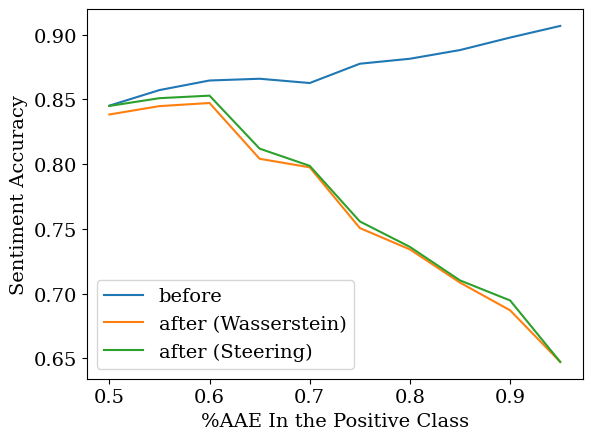

In [16]:
accs_after = [bias2clf_after[str(propr)].score(bias2data_after[str(propr)]["x_test"], bias2data_after[str(propr)]["y_test"]) for propr in props]
accs_before = [bias2clf_before[str(propr)].score(bias2data_before[str(propr)]["x_test"], bias2data_before[str(propr)]["y_test"]) for propr in props]
accs_After_steer = [bias2clf_after_steer[str(propr)].score(bias2data_after_steer[str(propr)]["x_test"], bias2data_after_steer[str(propr)]["y_test"]) for propr in props]

plt.plot(props, accs_before, label="before")
plt.plot(props, accs_after, label="after (Wasserstein)")
plt.plot(props, accs_After_steer, label="after (Steering)")
plt.xlabel("%AAE In the Positive Class", fontsize=14)
plt.ylabel("Sentiment Accuracy", fontsize=14)
# increase font
# increas xticks and yticks
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
#plt.savefig("results-tweets/acc.pdf", dpi=600)



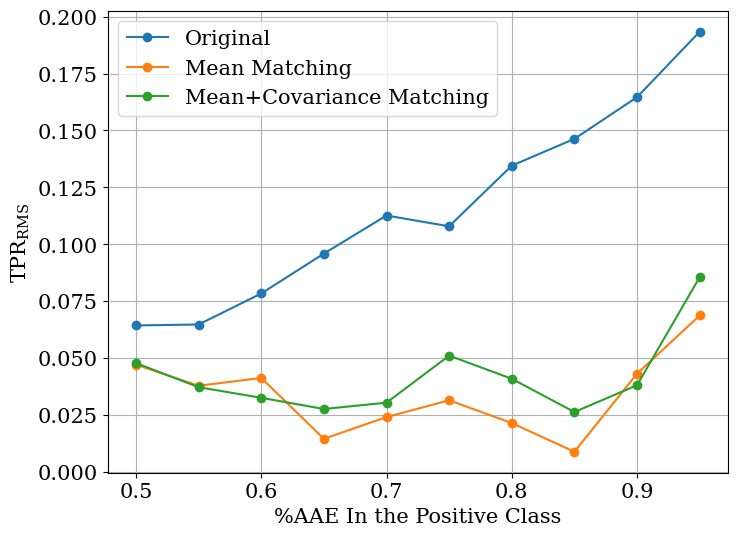

In [17]:
# plot
plt.rcParams["font.family"] = "serif"
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(8, 6))

plt.plot(props, tprs_before, label="Original",  marker="o")
plt.plot(props, tprs_after_steer, label="Mean Matching",  marker="o")
plt.plot(props, tprs_after, label="Mean+Covariance Matching",  marker="o")

plt.xlabel("%AAE In the Positive Class", fontsize=15)
plt.ylabel("$\mathregular{TPR_{RMS}}$", fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.grid()

plt.savefig("results-tweets/tpr_gap_llama.pdf", dpi=600)
plt.show()

In [18]:
# createa a df for the results

df = pd.DataFrame({"%AAE": props, "TPR Gap Before": tprs_before, "TPR Gap After (Mean+Covariance Matching)": tprs_after, "TPR Gap After (Mean Matching)": tprs_after_steer, "Accuracy Before": accs_before, "Accuracy After (Mean+Covariance Matching)": accs_after, "Accuracy After (Mean Matching)": accs_After_steer})

In [19]:
# chagne to 3 decimal points
df = df.round(3)
# save
df.to_csv("results-tweets/results_llama.csv", index=False)

In [20]:
df

,%AAE,TPR Gap Before,TPR Gap After (Mean+Covariance Matching),TPR Gap After (Mean Matching),Accuracy Before,Accuracy After (Mean+Covariance Matching),Accuracy After (Mean Matching)
0,0.50,0.064,0.048,0.047,0.845,0.838,0.845
1,0.55,0.065,0.037,0.038,0.857,0.845,0.851
2,0.60,0.078,0.032,0.041,0.865,0.847,0.853
3,0.65,0.096,0.028,0.014,0.866,0.804,0.812
4,0.70,0.113,0.030,0.024,0.863,0.798,0.799
5,0.75,0.108,0.051,0.031,0.878,0.751,0.756
6,0.80,0.134,0.041,0.021,0.881,0.734,0.736
7,0.85,0.146,0.026,0.009,0.888,0.709,0.710
8,0.90,0.165,0.038,0.043,0.898,0.687,0.695
9,0.95,0.193,0.086,0.069,0.907,0.647,0.647


In [21]:
# to latex
print(df.to_latex(index=False))

\begin{tabular}{rrrrrrr}
\toprule
%AAE & TPR Gap Before & TPR Gap After (Mean+Covariance Matching) & TPR Gap After (Mean Matching) & Accuracy Before & Accuracy After (Mean+Covariance Matching) & Accuracy After (Mean Matching) \\
\midrule
0.500000 & 0.064000 & 0.048000 & 0.047000 & 0.845000 & 0.838000 & 0.845000 \\
0.550000 & 0.065000 & 0.037000 & 0.038000 & 0.857000 & 0.845000 & 0.851000 \\
0.600000 & 0.078000 & 0.032000 & 0.041000 & 0.865000 & 0.847000 & 0.853000 \\
0.650000 & 0.096000 & 0.028000 & 0.014000 & 0.866000 & 0.804000 & 0.812000 \\
0.700000 & 0.113000 & 0.030000 & 0.024000 & 0.863000 & 0.798000 & 0.799000 \\
0.750000 & 0.108000 & 0.051000 & 0.031000 & 0.878000 & 0.751000 & 0.756000 \\
0.800000 & 0.134000 & 0.041000 & 0.021000 & 0.881000 & 0.734000 & 0.736000 \\
0.850000 & 0.146000 & 0.026000 & 0.009000 & 0.888000 & 0.709000 & 0.710000 \\
0.900000 & 0.165000 & 0.038000 & 0.043000 & 0.898000 & 0.687000 & 0.695000 \\
0.950000 & 0.193000 & 0.086000 & 0.069000 & 0.907000 & 0.647